Source: https://github.com/randerson112358/Python/blob/master/LSTM_Stock/LSTM2.ipynb

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

In [4]:
plt.style.use("fivethirtyeight")

In [5]:
df = web.DataReader('MSFT', data_source='yahoo', start='2012-01-01', end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,26.959999,26.389999,26.549999,26.770000,64731500.0,22.020796
2012-01-04,27.469999,26.780001,26.820000,27.400000,80516100.0,22.539021
2012-01-05,27.730000,27.290001,27.379999,27.680000,56081400.0,22.769344
2012-01-06,28.190001,27.530001,27.530001,28.110001,99455500.0,23.123066
2012-01-09,28.100000,27.719999,28.049999,27.740000,59706800.0,22.818701
...,...,...,...,...,...,...
2019-12-11,151.869995,150.330002,151.539993,151.699997,18856600.0,151.286774
2019-12-12,153.440002,151.020004,151.649994,153.240005,24612100.0,152.822586
2019-12-13,154.889999,152.830002,153.000000,154.529999,23845400.0,154.109070


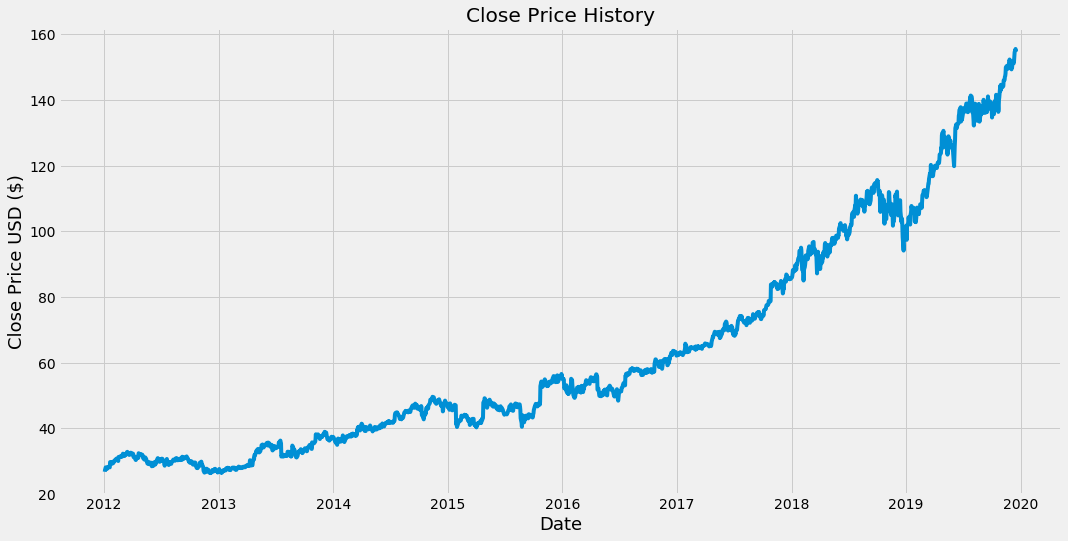

In [6]:
plt.figure(figsize=(16, 8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [7]:
data = df.filter(["Close"])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00309693],
       [0.0079746 ],
       [0.01014245],
       ...,
       [0.99225766],
       [1.        ],
       [0.99349647]])

In [9]:
STEP = 60

In [10]:
train_data = scaled_data[0:training_data_len, :]

x_train = np.array([train_data[i-STEP:i, 0] for i in range(STEP, training_data_len)])
y_train = np.array([train_data[i, 0] for i in range(STEP, training_data_len)])

In [11]:
ENTRY_COUNT = len(y_train)

In [12]:
x_train = x_train.reshape(ENTRY_COUNT, STEP, 1)
x_train.shape

(1543, 60, 1)

In [13]:
raw_dataset = [(x_train[i], y_train[i]) for i in range(ENTRY_COUNT)]
traindl = torch.utils.data.DataLoader(raw_dataset, shuffle=True, batch_size=50, num_workers=2)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(1, 50, num_layers=2)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = self.fc1(result)
        result = self.fc2(result)
        return result

In [15]:
net = Net().double()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [16]:
for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(traindl):
        optimizer.zero_grad()
        outputs = net(inputs.transpose(1, 0))
        loss = criterion(outputs.flatten(), labels.double())
        loss.backward()
        optimizer.step()
    
        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0

print("Finish training")

[1,   300] loss: 0.018800
[1,   600] loss: 0.005359
[2,   300] loss: 0.000185
[2,   600] loss: 0.000180
[3,   300] loss: 0.000188
[3,   600] loss: 0.000154
[4,   300] loss: 0.000184
[4,   600] loss: 0.000175
[5,   300] loss: 0.000193
[5,   600] loss: 0.000164
[6,   300] loss: 0.000156
[6,   600] loss: 0.000213
[7,   300] loss: 0.000169
[7,   600] loss: 0.000180
[8,   300] loss: 0.000169
[8,   600] loss: 0.000155
[9,   300] loss: 0.000136
[9,   600] loss: 0.000164
[10,   300] loss: 0.000169
[10,   600] loss: 0.000136
Finish training


In [17]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = torch.tensor([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = dataset[training_data_len:,:]
x_test = x_test.reshape(len(x_test), STEP, 1)

In [18]:
predictions = net(x_test.transpose(1, 0))
predictions = scaler.inverse_transform(predictions.detach().numpy())

In [19]:
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

4.244652243709254

/usr/local/miniconda3/envs/master-thesis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


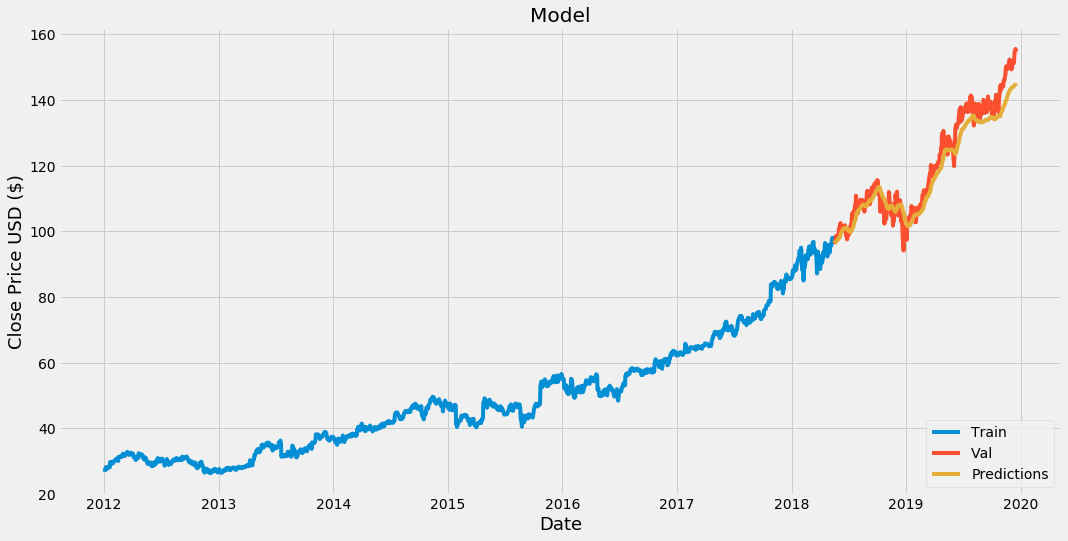

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [21]:
valid

,Close,Predictions
Date,,
2018-05-17,96.180000,96.445127
2018-05-18,96.360001,96.582272
2018-05-21,97.599998,96.668965
2018-05-22,97.500000,96.783269
2018-05-23,98.660004,96.901553
...,...,...
2019-12-11,151.699997,144.223883
2019-12-12,153.240005,144.339146
2019-12-13,154.529999,144.520142
